# 5.3 Region segmentation with DL based techniques

Deep Learning (DL) based techniques for region segmentation follow the typical pipeline of this Artificial Intelligence branch:
- A huge dataset with segmented regions is collected.
- A model arquitecture is designed.
- The model is trained with the dataset until its performance is over the application requirements.
- It is released/deployed.

In this notebook we will explore Segment Anything Model (SAM).

## Problem context - Region segmentation to calculate vegetation indices

In our country, climate change is causing serious problems for green areas, as periods of drought are becoming more frequent due to a lack of rain. This situation compromises the irrigation of gardens and crops, often leading to water supply cuts or the use of reclaimed water, which is not always ideal for plants.

Precision agriculture offers a way to mitigate this issue through the monitoring of green areas and the extraction of indices that can help estimate the plants' condition. These indices can measure factors like water stress (lack of water), the presence of disease, vegetative vigor, etc. With this information, we can provide tailored treatment to plants based on their specific needs, optimizing water usage and reducing waste.

<center><img src="https://raw.githubusercontent.com/jotaraul/cv_hub/refs/heads/main/segmentation/images_crops/expected_segmentation_and_ndvi_result_2.PNG" width="600"></center>

Computer vision to the rescue! In this practical exercise, our task is to segment trees visible in an image of a crop field captured by a drone. By doing so, we can extract personalized data for each tree, allowing us to provide the exact amount of water each one needs. This exercise introduces an essential application of computer vision in environmental sustainability and precision farming.




## Preparing our setup

To work with SAM you need to request GPUs power to Google colab. To do that click on "Entorno de ejecución" > "Cambiar tipo de entorno de ejecución".
Choose, for example, T4 GPU.

Let's start by installing the required python packages to work with SAM:

In [1]:
!pip3 install segment_anything
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth # Download model weights
# Model checkpoints
# vit_h, https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# vit_l, https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# vit_b, https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2024-11-05 16:05:19--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   170MB/s    in 22s     

2024-11-05 16:05:41 (109 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Now let's import the required libraries and modules:

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import argparse
import requests # to load content from the internet
from numba import cuda
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

Let's now explore the images we'll be working with. These include:

- **RGB Image:** This will be used for segmenting the visible regions (trees).
- **Near-Infrared (NIR) and Red Images:** These are essential for calculating vegetation indices, such as the NDVI, which help assess plant health.

All of these images were captured by a multispectral camera mounted on a drone during a flight over a crop field.

*Hint: if you try your own pictures, take care with their size, you can run out of memory. For example, in Colab that happens with images of size (3956, 5280, 3).*

[Image info]
RGB_Data size: (3956, 5280, 3)
NIR_Data size: (1944, 2592)
Red_Data size: (1944, 2592)
RGB_Data resized size: (1944, 2592, 3)


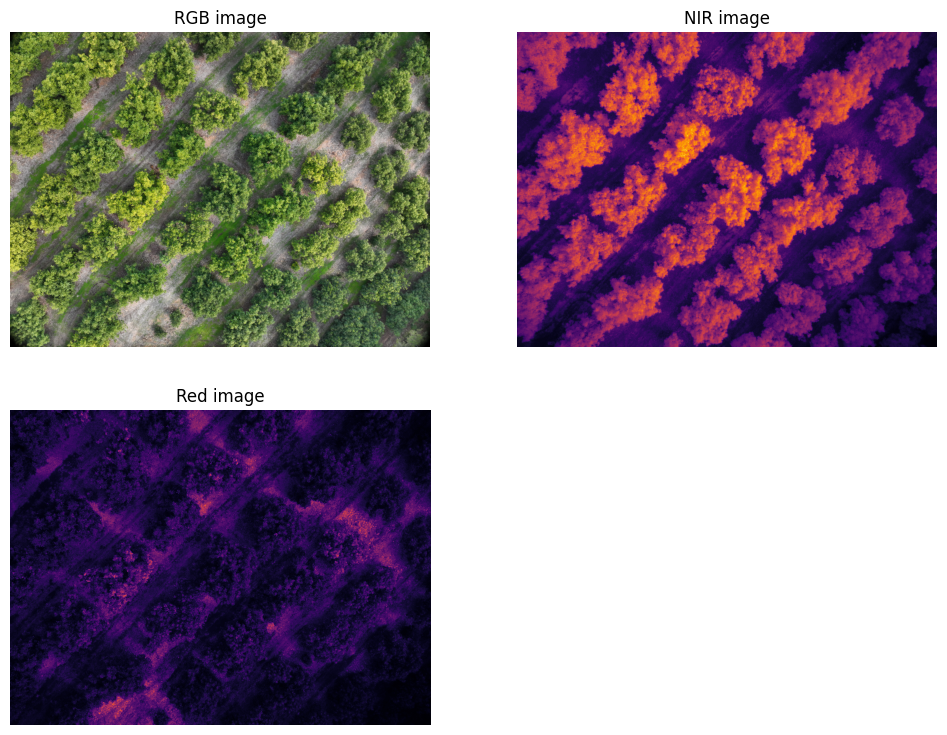

In [3]:
def load_image_from_url( url, image_type ):

  response = requests.get(url)
  image_data = np.frombuffer(response.content, np.uint8)  # Convert to a numpy array
  image = cv2.imdecode(image_data, image_type )
  return image

images_path = 'https://github.com/jotaraul/cv_hub/blob/main/segmentation/images_crops/'

image_RGB = load_image_from_url( images_path + '1_RGB.JPG?raw=true', cv2.IMREAD_COLOR)
image_NIR = load_image_from_url( images_path + '1_NIR.TIF?raw=true', cv2.IMREAD_GRAYSCALE)
image_R = load_image_from_url( images_path + '1_R.TIF?raw=true', cv2.IMREAD_GRAYSCALE)

# You can also load images from a local path / Google Drive, if you have
# When working with Google Colab, you have to provide access to your Google
# Drive so it can access your files, e.g., your images.
# This is done using the mount() function.
# from google.colab import drive
# drive.mount('/gdrive')
# images_path = '/gdrive/MyDrive/Colab Notebooks/Images Riego/'
# image_RGB = cv2.imread(images_path + '1_RGB.JPG')
# image_NIR = cv2.imread(images_path + '1_NIR.TIF', cv2.IMREAD_UNCHANGED)
# image_R=cv2.imread(images_path + '1_R.TIF',cv2.IMREAD_UNCHANGED)

print('[Image info]')

#print('Data type:',image.dtype)
print('RGB_Data size:', image_RGB.shape)
print('NIR_Data size:', image_NIR.shape)
print('Red_Data size:', image_R.shape)

# Resize RGB image to share dimensions with NIR and Red images
nir_height, nir_width = image_NIR.shape[:2]
image_RGB = cv2.resize(image_RGB, (nir_width, nir_height))
print('RGB_Data resized size:', image_RGB.shape)

image_RGB = cv2.cvtColor(image_RGB, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 9))

plt.subplot(2,2,1), plt.axis('off')
plt.title('RGB image')
plt.imshow(image_RGB)

plt.subplot(2,2,2), plt.axis('off')
plt.title('NIR image')
plt.imshow(image_NIR, cmap='inferno') # 'inferno' is good for high contrast in intensity

plt.subplot(2,2,3), plt.axis('off')
plt.title('Red image')
plt.imshow(image_R, cmap='inferno');

## Segment Anything Model (SAM)

SAM is a large language model developed by **Meta AI** (formerly Facebook AI Research). It was trained on the extensive SA-1B dataset, which contains 1.1 billion segmentation masks, enabling the model to generalize effectively to new, unseen data due to its exposure to a highly diverse dataset.

SAM can be used to generate masks for any image without needing labeled data. This marks a major breakthrough, as fully automated segmentation wasn't achievable before SAM.

What sets SAM apart is its role as the first **promptable segmentation** model. Users can guide the model's output using various prompts, including points, bounding boxes, text instructions, and even base masks.

Auxiliar function to show the SAM results:

## Choose a SAM model to work with.

You can choose from three options of checkpoint weights: ViT-B (91M), ViT-L (308M), and ViT-H (636M parameters). How do you choose the right one? The larger the number of parameters, the longer the time needed for inference, that is mask generation. If you have low GPU resources and fast inference, go for ViT-B. Otherwise, choose ViT-H.

In this notebook we previously downloaded the ViT-H checkpoint weights, but you can try the other ones.


In [4]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Segmenting every region in an image

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

```
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
```



For completeness, this is the full list of parameters, but you wouldn't need to modify most of them.

- `model` (Sam, default SAM): The SAM model to use for mask prediction.

- `points_per_side` (int or None, default 32): The number of points to be sampled along one side of the image. The total number of points is
`points_per_side**2`. If None, 'point_grids' must provide explicit point sampling.

- `points_per_batch` (int, default 64): Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.

- `pred_iou_thresh` (float, default 0.88): A filtering threshold in [0,1], using the model's predicted mask quality.

- `stability_score_thresh` (float, default 0.95): A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.

- `stability_score_offset` (float, default 1.0): The amount to shift the cutoff when calculated the stability score.
          
- `box_nms_thresh` (float, default 0.7): The box IoU cutoff used by non-maximal suppression to filter duplicate masks.

- `crop_n_layers` (int, default 0): If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.

- `crop_nms_thresh` (float, 0.7): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
          
- `crop_overlap_ratio` (float, default 512/1500): Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.

- `crop_n_points_downscale_factor` (int, default 1): The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

- `point_grids` (list(np.ndarray) or None, default None): A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.

- `min_mask_region_area` (int, default 0): If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.

- `output_mode` (str, default "binary_mask"): The form masks are returned in. Can be 'binary_mask', 'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools. For large resolutions, 'binary_mask' may consume large amounts of memory.

Cool! Let's create the automatic mask generator object:

In [5]:
sam.cuda()
mask_generator = SamAutomaticMaskGenerator(sam,
                                           stability_score_thresh=0.96,
                                           min_mask_region_area=100)

`SamAutomaticMaskGenerator` returns a list of masks, where each mask is a dict containing various information about the mask:

- `segmentation` - [np.ndarray] - the mask with (W, H) shape, and bool type.
- `area` - [int] - the area of the mask in pixels
- `bbox` - [List[int]] - the boundary box of the mask in xywh format
- `predicted_iou` - [float] - the model's own prediction for the quality of the mask
- `point_coords` - [List[List[float]]] - the sampled input point that generated this mask
- `stability_score` - [float] - an additional measure of mask quality
- `crop_box` - List[int] - the crop of the image used to generate this mask in xywh format.

## *ASSIGNMENT 1: Region segmentation with SAM, how the output looks like?*

Our first task is to run our `mask_generator`to retrieve the masks that SAM segments in the RGB image.

In [8]:
# Measure the time taken for mask generation
start_time = time.time()  # Start timing

# Generate masks
masks = mask_generator.generate(image_RGB)

end_time = time.time()  # End timing
time_taken = end_time - start_time

print('[Results info]')

print(f"Time taken to generate masks: {time_taken:.2f} seconds")

[Results info]
Time taken to generate masks: 17.35 seconds


Now, in the next code cell, implement the needed code to print the total number of masks detected by SAM, and the content of the first mask (segmentation, area, etc.).

In [9]:
print('[Results info]')

print('Number of masks:', len(masks))

print('Mask[0] data:')
for k,v in masks[0].items():
  print (k,v)

[Results info]
Number of masks: 101
Mask[0] data:
segmentation [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
area 79361
bbox [795, 32, 349, 394]
predicted_iou 1.0044721364974976
point_coords [[850.5, 151.875]]
stability_score 0.9818553924560547
crop_box [0, 0, 2592, 1944]


Expected output similar to:

```
[Results info]
Number of masks: 101
Mask[0] data:
segmentation [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
area 79361
bbox [795, 32, 349, 394]
predicted_iou 1.0044721364974976
point_coords [[850.5, 151.875]]
stability_score 0.9818553924560547
crop_box [0, 0, 2592, 1944]
```

## *ASSIGNMENT 2: Computing NDVI values of vegetation*

The **Normalized Difference Vegetation Index (NDVI)** is a popular index used in remote sensing to assess vegetation health and density. It measures the difference between the Near-Infrared (NIR) and Red (R) spectral bands, which are sensitive to vegetation:

- NIR: Healthy vegetation reflects strongly in the Near-Infrared band.
- Red: Vegetation absorbs light in the Red band for photosynthesis, leading to low reflection.

The NDVI is calculated using the formula:

$$
NDVI = \frac{(NIR+Red)}{(NIR−Red)}
​$$

Values range from -1 to 1:
- Close to 1: Healthy, dense vegetation.
- Close to 0: Bare soil or sparse vegetation.
- Negative values: Water, clouds, or non-vegetative features.

Using the multispectral images provided (NIR and Red), your task is to compute the NDVI values of the entire image and show them.

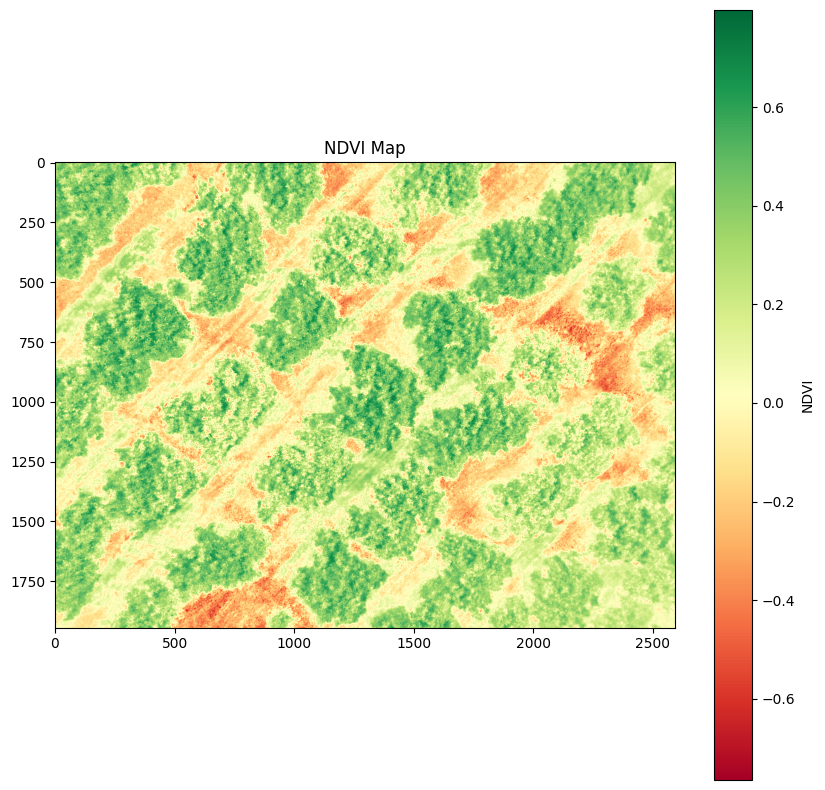

In [10]:
# Convert the bands to float for NDVI calculation
nir_band = image_NIR.astype(float)
red_band = image_R.astype(float)

# Compute NDVI: (NIR - Red) / (NIR + Red)
ndvi = (nir_band - red_band)/(nir_band + red_band)

# Display the NDVI image using a color map
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap="RdYlGn")  # RdYlGn for a green-to-red color map (green = healthy vegetation)
plt.colorbar(label='NDVI')
plt.title("NDVI Map")
plt.show();

Expected output:

<img src="https://raw.githubusercontent.com/jotaraul/cv_hub/refs/heads/main/segmentation/images_crops/expected_ndvi_computation_result_1.PNG" width="400">

Our goal now will be to compute the mean and standard deviation of the ndvi values of the segmented regions. But first, let's start just by using the `np.ma.masked_where()` function along with the segmentation mask of the first detected one (`masks[0]`) and the computed ndvi values to produce a masked_image where just `true` values in the segmentation mask take their ndvi values.

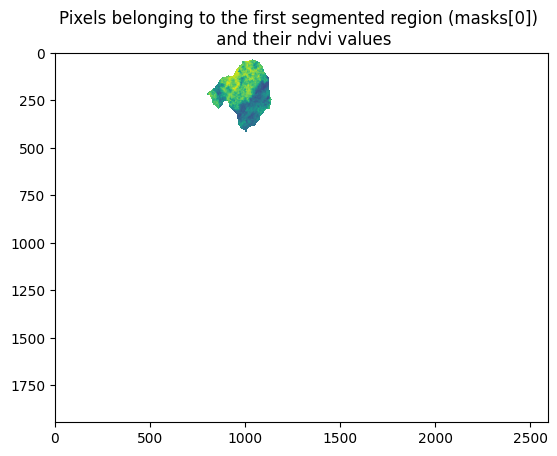

In [13]:
# Get the masked image
masked_image = np.ma.masked_where(~masks[0]['segmentation'], ndvi)

# Show it!
plt.imshow(masked_image)
plt.title('Pixels belonging to the first segmented region (masks[0]) \n and their ndvi values');

Expected output:

<img src="https://raw.githubusercontent.com/jotaraul/cv_hub/refs/heads/main/segmentation/images_crops/expected_masked_image_result_1.PNG" width="400">

Now that you know how to generate an image with just the ndvi values of a segmented region, let's compute the mean and standard deviation of those values per region. Then, they are included in the dictionary of each mask.

In [29]:
# Iterate over the masks
for mask in masks:
  # Get the masked image
  masked_image = np.ma.masked_where(~mask['segmentation'], ndvi)
  # Compure and store the mean
  mask['nvdi_mean'] = masked_image.mean()
  # Compute and store the standard deviation
  mask['nvdi_stdv'] = masked_image.std()

## *ASSIGNMENT 3: Visualizing the results*

Wow! We did a great job segmenting the regions appearing in the RGB image, computing the ndvi values using the NIR and Red ones, and retrieving their mean and standard deviation values of each mask. But something is missing... it would be cool to visualize the result of all this effort, isn't it?

Your task is to complete the following function that, over the initial RGB image, shows the $n$ biggest masks, and uses their mean ndvi value to draw in the middle of their bounding boxes a circle which color means:

- Green: healthy vegetation.
- Orange: Bare soil or sparse vegetation.
- Red:  Water, clouds, or non-vegetative features.

In [30]:
def show_segmented_regions(image, masks, show_n_biggest=0):

    if len(masks) == 0:
        return

    plt.figure(figsize=(12, 9))

    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

    if show_n_biggest:
      sorted_masks = sorted_masks[:show_n_biggest]

    # Let's create an image with transparency, being the fourth channel said
    # transparency
    image_masks = np.ones((sorted_masks[0]['segmentation'].shape[0],
                          sorted_masks[0]['segmentation'].shape[1],
                          4))
    image_masks[:,:,3] = 0

    # Only show nvdi_means if they have been computed
    if 'nvdi_mean' in sorted_masks[0]:
      image_circles = np.ones_like(image_masks, dtype=float)
      image_circles[:,:,3] = 0

    for mask in sorted_masks:

        m = mask['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        image_masks[m] = color_mask

        if 'nvdi_mean' in mask:

          bbox = mask['bbox']

          if mask['nvdi_mean'] > 0.3:
            cv2.circle(image_circles,(int(bbox[0]+bbox[2]*0.5),int(bbox[1]+bbox[3]*0.5)), 25, (0,1,0,0.9), -1)

          elif mask['nvdi_mean'] >0:
            cv2.circle(image_circles,(int(bbox[0]+bbox[2]*0.5),int(bbox[1]+bbox[3]*0.5)), 25, (1,0.5,0,0.9), -1)

          else:
            cv2.circle(image_circles,(int(bbox[0]+bbox[2]*0.5),int(bbox[1]+bbox[3]*0.5)), 25, (1,0,0.9), -1)

    plt.imshow(image)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ax.imshow(image_masks)

    if 'nvdi_mean' in sorted_masks[0]:
      ax.imshow(image_circles)

In [ ]:
show_n_biggest = 10
show_segmented_regions(image_RGB, masks, show_n_biggest)

Expected result (showing the 10 biggest masks):

<img src="https://raw.githubusercontent.com/jotaraul/cv_hub/refs/heads/main/segmentation/images_crops/expected_segmentation_and_ndvi_result_1.PNG" width="400">

## Conclusion

Congratulations on completing this notebook! 🎉

In this notebook, we explored the power of **Deep Learning (DL)** techniques for **region segmentation** using the cutting-edge **Segment Anything Model (SAM)**. We went through the process of:

1. **Loading and Visualizing Multispectral Data**: We worked with **RGB**, **Near-Infrared (NIR)**, and **Red** images captured by a multispectral camera mounted on a drone, which provided us with the necessary data to monitor vegetation.
   
2. **Segmenting Regions with SAM**: You successfully used the **Segment Anything Model (SAM)** to segment individual trees from the RGB image, demonstrating SAM's ability to generalize effectively without requiring labeled data.

3. **Computing NDVI (Normalized Difference Vegetation Index)**: Using the NIR and Red bands, you computed the **NDVI**, a crucial index in precision agriculture that helps monitor the health and vigor of vegetation. We applied NDVI on the segmented trees, which allowed for personalized monitoring of each tree's health based on its spectral properties.

4. **Visualizing Results**: The final visualization included not only the segmented regions but also overlaid **NDVI values** represented by color-coded circles, allowing for an easy assessment of vegetation health across the entire image.

Through this notebook, you've gained hands-on experience with **multispectral image analysis**, **region segmentation using SAM**, and the **computation and interpretation of NDVI**, which are relevant tools in the fields of **remote sensing** and **precision agriculture**.

Well done! You've taken important steps toward understanding how computer vision can be applied to solve real-world problems in environmental monitoring and sustainability. 🌱


## This notebook was designed using the following sources of information:
- SAM paper: https://arxiv.org/abs/2304.02643
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py